In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
twitter_df = pd.read_csv('twitter-archive-enhanced.csv')
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

In [3]:
#to read json in a dataframe with the columns specified

with open('tweet_json.txt', 'r') as f:
    twitter_json = pd.read_json(f, lines=True)
twitter_json = twitter_json[['id','favorite_count','retweet_count']]
twitter_json.head(1)

,id,favorite_count,retweet_count
0,892420643555336193,36401,7746


In [4]:
image_predictions = pd.read_csv('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv', sep = '\t')

In [5]:
image_predictions.to_csv('test.csv', index = False)

In [6]:
# to merge all dataframes to populate one table for easy review

twitter_one = pd.merge(twitter_df, twitter_json, left_on='tweet_id', right_on='id', how='left').drop('id', axis=1)
twitter = pd.merge(twitter_one, image_predictions, on = 'tweet_id')

In [7]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2075 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2075 non-null   object 
 4   source                      2075 non-null   object 
 5   text                        2075 non-null   object 
 6   retweeted_status_id         81 non-null     float64
 7   retweeted_status_user_id    81 non-null     float64
 8   retweeted_status_timestamp  81 non-null     object 
 9   expanded_urls               2075 non-null   object 
 10  rating_numerator            2075 non-null   int64  
 11  rating_denominator          2075 non-null   int64  
 12  name                        2075 non-null   object 
 13  doggo                       2075 

In [8]:
twitter.favorite_count.isna().sum().sum()

16

In [9]:
#Tidiness: Fill the NaN value for consistency.

twitter.favorite_count.fillna(0, inplace= True)
twitter.retweet_count.fillna(0, inplace = True)

In [10]:
# Quality Issue: to remove rows that contain retweets by selecting rows that contain the string "RT"

twitter = twitter[~twitter.text.str.contains('RT @')]

In [11]:
#Quality Issue: Once the rows with retweets got deleted, these columns will have no value. Hence, the deletion.

twitter.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis = 1, inplace = True)

In [12]:
#Quality Issue: Rows contain missing values.

twitter.drop(['in_reply_to_status_id', 'in_reply_to_user_id'], axis = 1, inplace = True)

In [13]:
#Quality Issue: Difference datatypes. To change them to appropriate dtypes.

twitter.timestamp = pd.to_datetime(twitter.timestamp)

twitter['favorite_count'] = twitter['favorite_count'].astype(int)

twitter['retweet_count'] = twitter['retweet_count'].astype(int)

In [14]:
# Column 'name' contains names that are not consistently capitalised.

twitter['name'].str.title()

0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
          ...   
2070        None
2071           A
2072           A
2073           A
2074        None
Name: name, Length: 1994, dtype: object

##### Other Quality Issues:
1. Column 'name' contains peculiar names like 'a' and 'none'.
2. Column 'expanded url' contains inconsistent url data. Some rows have more than one url.
3. Rating numerator have values above 100 and more, above the usual range. 


##### Other Tidiness Issues:
1. Columns 'img_num', 'p1' to 'p3', 'p1_conf' to 'p3_conf' and 'p1_dog' to 'p3_dog' can be grouped/collapsed as/into one big column.
2. Dog stages can be grouped as one column.

In [15]:
# to save df to csv

twitter.to_csv('twitter_archive_master.csv', index= False)

In [16]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2074
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1994 non-null   int64              
 1   timestamp           1994 non-null   datetime64[ns, UTC]
 2   source              1994 non-null   object             
 3   text                1994 non-null   object             
 4   expanded_urls       1994 non-null   object             
 5   rating_numerator    1994 non-null   int64              
 6   rating_denominator  1994 non-null   int64              
 7   name                1994 non-null   object             
 8   doggo               1994 non-null   object             
 9   floofer             1994 non-null   object             
 10  pupper              1994 non-null   object             
 11  puppo               1994 non-null   object             
 12  favorite_count      1994 non-null 

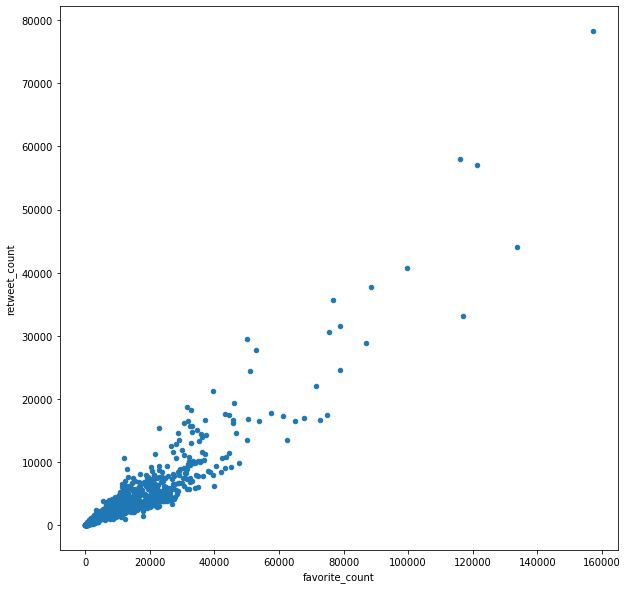

In [17]:
# to find out how many of the favourites were retweeted.

twitter.plot(kind= 'scatter', x = 'favorite_count', y = 'retweet_count', figsize = (10,10));

The plot shows a concregation within the 40000 around which the tweets were retweeted. The most favourite has been the most retweeted. However, the data shows that most retweets do not go beyond a certain range.

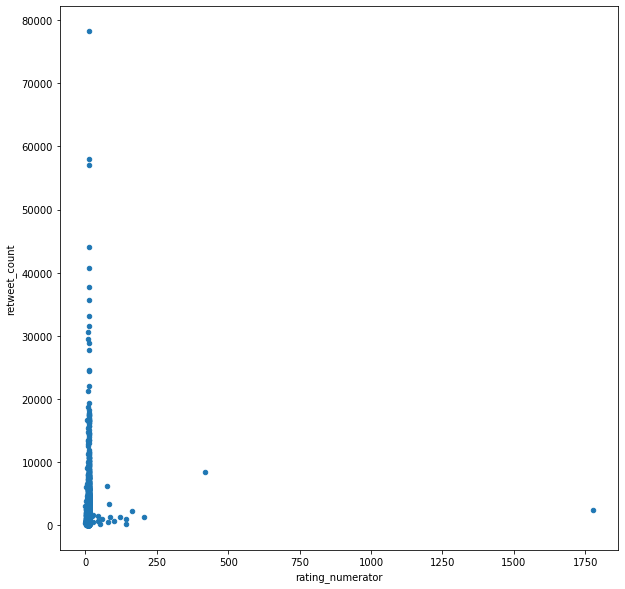

In [18]:
# how the retweets stand against the rating_numerator

twitter.plot(kind= 'scatter', x = 'rating_numerator', y = 'retweet_count', figsize = (10,10));

The plot shows outliers. The highest rating were not retweet the most. Most retweets received ratings under quarter of 250.

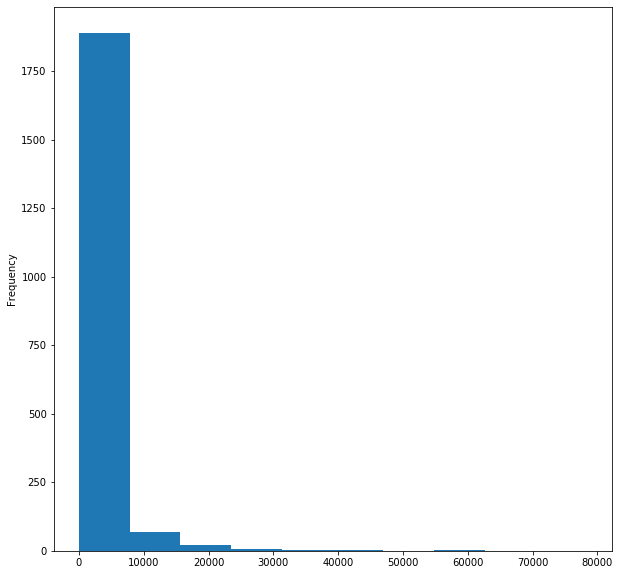

In [19]:
# to show the frequency of retweets.

twitter['retweet_count'].plot(kind= 'hist', figsize = (10,10));

There is missing data just before and after the 50000 retweets.

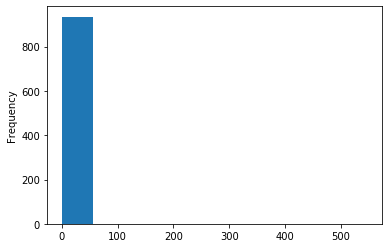

In [20]:
# to find the most common dog names.

twitter['name'].value_counts().plot(kind = 'hist');

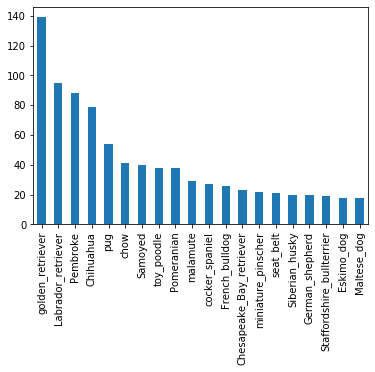

In [70]:
# Most predicted dog breed for each prediction

pd.value_counts(twitter['p1']).head(20).plot.bar();

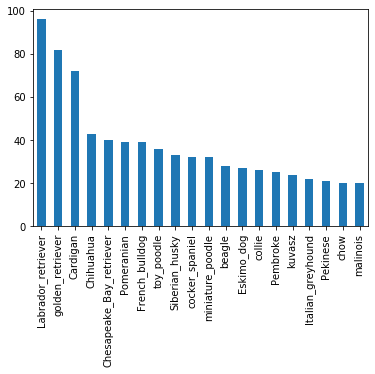

In [71]:
pd.value_counts(twitter['p2']).head(20).plot.bar();

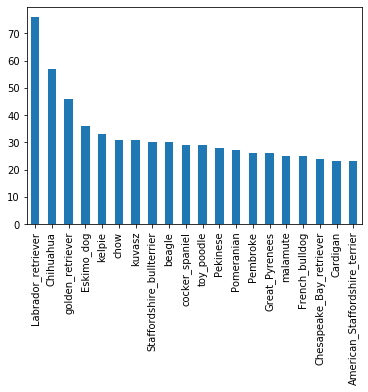

In [72]:
pd.value_counts(twitter['p3']).head(20).plot.bar();

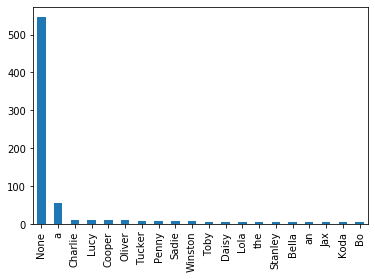

In [56]:
# to know the most common dog names.

pd.value_counts(twitter['name']).head(20).plot.bar();